In [1]:
push!(LOAD_PATH, pwd()*"/..")
using SIS,IM,PayloadGraph,PyPlot, Epidemics,JLD,
TwoLevelGraphs,Dierckx,Plotting,DataAnalysis,GraphGeneration,TwoDegree,
DegreeDistribution,Clustering
import LightGraphs



Use "Dict(a=>b for (a,b) in c)" instead.


In [2]:
function load_p_reach_data(path)
    d = load(path)

    params = d["params"]
    compact = params["compact"]
    runs = d["runs"]
    if compact
        sizes = runs.sizes
        pvals = runs.p_reach
        yvals = runs.y_reach
        num_trials = runs.num_trials
    else
        num_fixed = get_num_fixed(runs) #d["num_fixed"]
        sizes = get_sizes(runs) #d["sizes"]
        yvals,pvals = get_p_reach(runs,params["N"])
        num_trials = length(runs)
    end
    
    epidemic_params = QuadraticEpidemicParams(params["N"],params["alpha"],params["beta"])
    
    k = params["k"]
    graph_information = params["graph_information"]
    graph_type = params["graph_type"]
    return params,yvals,pvals,epidemic_params,k,graph_information,graph_type,runs,num_trials
end
    
# function summarize_p_reach_data(path)
#     params,yvals,pvals,epidemic_params,k,graph_information,graph_type,runs,num_trials = load_p_reach_data(path)
#     N = epidemic_params.N
#     alpha = epidemic_params.alpha
#     beta = epidemic_params.beta
#     n_n = epidemic_params.n_n
#     c_r = epidemic_params.c_r
 
#     println("N = $N, k = $k, y_n = $(n_n/N), c_r = $(c_r)")
#     println("alpha = $(alpha), beta = $(beta)")
#     println("Graph Type: $(graph_type)")
#     if graph_type == Int(two_level_rg)
#         t = graph_information.data.t
#         println("k_i = $(t.l), k_e = $(t.r)")
#     end
#     if graph_type == Int(gamma_rg) ||graph_type == Int(two_degree_rg)
#         sigma_k = graph_information.data
#         println("sigma_k = $(sigma_k)")
#     end
#     println("num trials: $(num_trials)")
        
# end

function plot_comparisons(paths,apply_finite_size=true)
    N,n_n,c_r,alpha,beta,k,xx,yy,s_eff_two_level,splus_two_level = 0,0,0,0,0,0,0,0,0,0
    l,r = 0,0
    has_two_level= false
    yvals_simulation,pvals_simulation = [],[]
    yvals_theory,pvals_theory = [],[]
    yvals_wm_sim,pvals_wm_sim = [],[]
    yvals_tl_theory,pvals_tl_theory = [],[]
    ims = []
    simulation_labels = []
    theory_labels = []
    num_trials_arr = []
    num_trials_wm = 100
    for (idx,path) in enumerate(paths)
        hypergeometric = true
        params,yvals,pvals,epidemic_params,k,graph_information,graph_type,runs,num_trials = load_p_reach_data(path)
        N = epidemic_params.N
        alpha = epidemic_params.alpha
        beta = epidemic_params.beta
        n_n = epidemic_params.n_n
        c_r = epidemic_params.c_r
    
        push!(num_trials_arr,num_trials)
        push!(yvals_simulation,yvals)
        push!(pvals_simulation,pvals)
        yy = collect(1/N:0.001:1)
        pp = 0
        label = "default"
        println(graph_type)
        num_runs = 2000
        num_points = 200

        if graph_type == Int(two_level_rg)
            has_two_level = true
            t = graph_information.data.t
#             @time yy_wm,pp_wm = get_p_reach_well_mixed_two_level_simulation(TwoLevel(t.N,t.m,t.l,t.r),alpha,beta,N,num_runs)
            yy,pp,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N,apply_finite_size,num_points)
            println(t)
            label = "Two Level \$k_i = $(t.l), k_e = $(t.r)\$"
#             imk = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
        elseif graph_type == Int(scale_free_rg )
            im = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_scale_free(x,alpha,beta,k,N) , x -> 1 + beta)
            pp = P_reach_fast(im,N,1.0/N,yy,true)
#             yy_wm,pp_wm = get_p_reach_well_mixed_simulation(im,N,num_runs)
            label = "SF \$k = $k\$"
        elseif graph_type == Int(gamma_rg)
            #k = t.l + t.r
            sigma_k = graph_information.data
            im = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_gamma(x,alpha,beta,k,sigma_k,N) , x -> 1 + beta)
            pp = P_reach_fast(im,N,1.0/N,yy,true)
            tdp = compute_two_degree_params(k,sigma_k)
#             yy_wm,pp_wm,_ = get_p_reach_well_mixed_two_degree_simulation(alpha,beta,N,tdp,num_trials)
            degr_distr = get_p_k_gamma(sigma_k,k,3)
            p_k,p_k_neighbor,mean_k = get_p_k_as_vec(degr_distr,N);
#             hypergeometric = sigma_k >= k
            @time yy_wm,pp_wm,_ = get_p_reach_well_mixed_by_degree_simulation(N,alpha,beta,p_k,p_k_neighbor,num_trials_wm,hypergeometric)
#             yy_wm,pp_wm = get_p_reach_well_mixed_simulation(im,N,num_runs)
            label = "GAMMA \$ k = $k ,\\sigma_{k} = $(sigma_k) \$"
        elseif graph_type == Int(two_degree_rg)
            sigma_k = graph_information.data
            im = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_gamma(x,alpha,beta,k,sigma_k,N) , x -> 1 + beta)
            pp = P_reach_fast(im,N,1.0/N,yy,true)
            tdp = compute_two_degree_params(k,sigma_k)
#             yy_wm,pp_wm,_ = get_p_reach_well_mixed_two_degree_simulation(alpha,beta,N,tdp,num_trials)
            degr_distr = get_p_k_two_degree(tdp)
            p_k,p_k_neighbor,mean_k = get_p_k_as_vec(degr_distr,N);
            @time yy_wm,pp_wm,_ = get_p_reach_well_mixed_by_degree_simulation(N,alpha,beta,p_k,p_k_neighbor,num_trials_wm,hypergeometric)
#             yy_wm,pp_wm = get_p_reach_well_mixed_simulation(im,N,num_runs)
            label = "TWO DEGREE \$ k = $k ,\\sigma_{k} = $(sigma_k) \$"
        elseif graph_type == Int(regular_rg )
            im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
            pp = P_reach_fast(im,N,1.0/N,yy,true)
#             @time yy_wm,pp_wm = get_p_reach_well_mixed_simulation(im,N,num_runs)
            label = "Regular \$k = $k \$"
        elseif graph_type == Int(clustering_rg )
            C = graph_information.data
            @time yy_wm,pp_wm,edge_counts = Clustering.get_p_reach_well_mixed_with_clustering(N,k,C,alpha,beta,num_trials_wm,1-1/N);
#             im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
#             pp = P_reach_fast(im,N,1.0/N,yy,true)
            t =get_optimal_tl_params(N,k,C)
#             @time yy_wm,pp_wm = get_p_reach_well_mixed_two_level_simulation(TwoLevel(t.N,t.m,t.l,t.r),alpha,beta,N,num_runs)
            yy,pp,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N,apply_finite_size,num_points)
            
#             @time yy_wm,pp_wm = get_p_reach_well_mixed_simulation(im,N,num_runs)
            label = "Clustering \$C = $C \$"
        end
        println(label)
        push!(yvals_theory,yy)
        push!(pvals_theory,pp)
        push!(yvals_wm_sim,yy_wm)
        push!(pvals_wm_sim,pp_wm)
        push!(theory_labels,latexstring(label))
        push!(simulation_labels,latexstring("Sim. "*label))
       
    end
    
    
    #plotting
    figure()
    
    
    colors = ["b","g","r","k","c","m","y"]
    symbols = ["o","s","^","p","v","h","*"]
    colors = repmat(colors,3)
   
    for i = 1:length(yvals_theory)
        loglog(yvals_theory[i],pvals_theory[i],"-",color=colors[i])#,label=theory_labels[i])
    end
    for i = 1:length(yvals_wm_sim)
        ppp = pvals_wm_sim[i]
        errorbars = 2*(ppp.*(1-ppp)/num_trials_wm).^0.5
#         plt[:errorbar](yvals_wm_sim[i],pvals_wm_sim[i],linestyle="--",yerr=errorbars,color=colors[i])#,label=simulation_labels[i])
#         loglog(yvals_wm_sim[i],pvals_wm_sim[i],"-",linewidth=1,color=colors[i])#,label=theory_labels[i])
    end
    for i = 1:length(yvals_simulation)
        ppp = pvals_simulation[i]
        errorbars = 2*(ppp.*(1-ppp)/num_trials_arr[i]).^0.5
        plt[:errorbar](yvals_simulation[i],pvals_simulation[i],linestyle="none",yerr=errorbars,color=colors[i],linewidth=1,label=simulation_labels[i])
#         loglog(yvals_simulation[i],pvals_simulation[i],symbols[i],fillstyle="none",color=colors[i],linewidth=1,label=simulation_labels[i])
    end
    
    #plot well mixed
    im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta)
    yywm = collect(1/N:0.001:1)
    ppwm = P_reach_fast(im_normal,N,1.0/N,yywm,true)
    labelwm = "Well Mixed"
    loglog(yywm,ppwm,"-.k",label=labelwm)
    
#     pygui(false)
    legend(loc="best",fontsize=12)
    ylim([1e-4,1])
    xlim([1/N,1.1])
    xlabel(L"y",size=20)
    ylabel(L"P_{reach}(y)",size=20)
    title(latexstring("\$y_n = $(round(n_n/N,2)), c_r = $(round(c_r,2)), N = $N, k = $k\$"))
end
    
           

plot_comparisons (generic function with 2 methods)

In [3]:
tdp = compute_two_degree_params(k,sigmak)
yy,pp,_ = get_p_reach_well_mixed_two_degree_simulation(alpha,beta,N,tdp,trials)

LoadError: UndefVarError: k not defined

In [3]:
data_dir_path = "../../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"
filenames = split(readstring(`ls $data_dir_path`));
filenames[end-10:end]

for (i,filename) in enumerate(filenames[end-12:end-4])
    println(i)
    summarize_p_reach_data(data_dir_path*filename)
end

# summarize_p_reach_data(data_dir_path*filenames[end-2])

1
N = 2000, k = 10, y_n = 0.09999999999999999, c_r = 0.30000000000000004
alpha = 0.6666666666666667, beta = 0.06666666666666667
Graph Type: 7
num trials: 10000
2
N = 2000, k = 10, y_n = 0.09999999999999999, c_r = 0.30000000000000004
alpha = 0.6666666666666667, beta = 0.06666666666666667
Graph Type: 7
num trials: 10000
3
N = 2000, k = 10, y_n = 0.09999999999999999, c_r = 0.30000000000000004
alpha = 0.6666666666666667, beta = 0.06666666666666667
Graph Type: 7
num trials: 10000
4
N = 400, k = 10, y_n = 0.1, c_r = 0.3
alpha = 3.333333333333333, beta = 0.3333333333333333
Graph Type: 7
num trials: 10000
5
N = 400, k = 10, y_n = 0.1, c_r = 0.3
alpha = 3.333333333333333, beta = 0.3333333333333333
Graph Type: 7
num trials: 10000
6
N = 400, k = 10, y_n = 0.1, c_r = 0.3
alpha = 3.333333333333333, beta = 0.3333333333333333
Graph Type: 7
num trials: 10000
7
N = 10000, k = 10, y_n = 0.1, c_r = 0.29999999999999993
alpha = 0.13333333333333333, beta = 0.013333333333333334
Graph Type: 7
num trials: 1000

7
  0.022764 seconds (339.00 k allocations: 8.276 MB, 39.08% gc time)


Optimization Services Solver
Main Authors: Horand Gassmann, Jun Ma, and Kipp Martin
Distributed under the Eclipse Public License
OS Version:  2.9.3
Build Date: Oct 24 2016




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Objective is: 0.00012822347038992252
Solution is:
ki = 5.0
m = 10.0
Expected C = 0.11132358028142701
Clustering $C = 0.1 $
7
  2.357205 seconds (58.16 M allocations: 1.366 GB, 21.49% gc time)


Optimization Services Solver
Main Authors: Horand Gassmann, Jun Ma, and Kipp Martin
Distributed under the Eclipse Public License
OS Version:  2.9.3
Build Date: Oct 24 2016

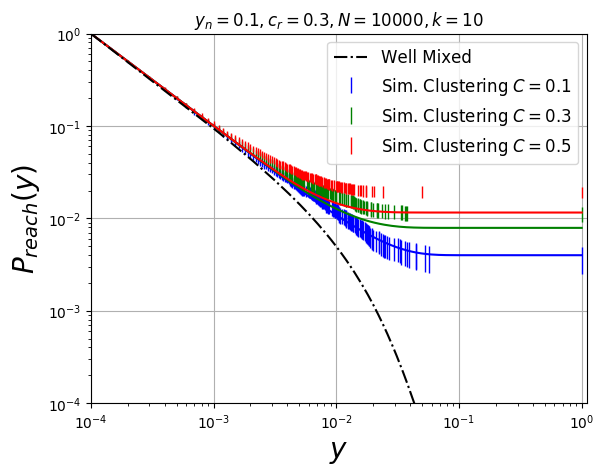

In [8]:
path_regular = data_dir_path*filenames[end-3]
path_two_level = data_dir_path*filenames[end-1]
subpaths = []
# push!(subpaths,filenames[12])
# subpaths = vcat(subpaths,filenames[end-4:end-1])
# subpaths = vcat(subpaths,filenames[end-9:end-9])
# subpaths = vcat(subpaths,filenames[end-9:end-7])
# subpaths = vcat(subpaths,filenames[end-41:end-40])
subpaths = vcat(subpaths,filenames[end-6:end-4])
# push!(subpaths,filenames[end-38])
paths = [data_dir_path*_ for _ in subpaths]
close("all")
# s_t_l,splus_t_l = plot_comparison(path_regular,path_two_level,true)
plot_comparisons(paths,true)
# gca()[:set_xscale]("linear")
gcf()
ylim([1e-4,1])
grid()
# imtl = InfectionModel(x -> 1 + beta + s_t_l(x) , x -> 1 + beta);
# runs_well_mixed_tl = run_epidemics(10000, () -> run_epidemic_well_mixed(N,imtl,1.0));
# yvals_well_mixed_tl,pvals_well_mixed_tl = get_p_reach(runs_well_mixed_tl,N)
# figure(2)
# plot(yvals_well_mixed,pvals_well_mixed,"^b")
# plot(yvals_well_mixed_full,pvals_well_mixed_full,"^r")
# plot(yvals_well_mixed_tl,pvals_well_mixed_tl,"^k")

In [5]:
using JuMP
using CoinOptServices

function get_optimal_tl_params(N,k,C)

    mod = Model(solver=OsilBonminSolver())
    @variable(mod,ki_v, Int)
    @variable(mod,m_vh, Int)

    @NLobjective(mod,Min,(C - (ki_v*(ki_v-1)*(ki_v-1)/(2*m_vh-2) + (k-ki_v)*((k-ki_v)-1)*((N-2*2*m_vh)*((k-ki_v)-1)/(N-2*m_vh)^2 + (2*m_vh/(N-2*m_vh))*(ki_v/(2*m_vh-1))) )/ (k*(k-1)))^2)    
    @NLconstraint(mod,ki_v <= 2*m_vh-1)
    @NLconstraint(mod,1 <= ki_v <= k-1)
    @NLconstraint(mod,1 <= 2*m_vh <= N/2)
    @NLconstraint(mod, 2*m_vh == k)
    # @NLconstraint(mod,ki_v*m_v/2 == round(ki_v*m_v/2))

    # Solve problem using MIP solver
    status = solve(mod)

    println("Objective is: ", getobjectivevalue(mod))
    println("Solution is:")
    println("ki = ",getvalue(ki_v))
    println("m = ",2*getvalue(m_vh))


    ki = Int(getvalue(ki_v))
    m = Int(2*getvalue(m_vh) )
    t1 = TwoLevel(Int(ceil(N/m)*m),m,ki,k-ki)
    println("Expected C = ", get_expected_clustering(t1))
#     T = generate_regular_two_level_graph(t1)
#     println(mean(local_clustering_coefficient(T)))
    return t1
end

function get_expected_clustering(k,N,ki,m)
    ke = k - ki 
    C_i = (ki-1)/(m-2)
    C_e = (N-2*m)*(ke-1)/(N-m)^2 + (m/(N-m))*(ki/(m-1))
    return (ki*(ki-1)*C_i + ke*(ke-1)*C_e )/ (k*(k-1))
end

function get_expected_clustering(t::TwoLevel)
    return get_expected_clustering(t.l + t.r,t.N,t.l,t.m)
end

INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/JuMP.ji for module JuMP.
INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/LightXML.ji for module LightXML.


get_expected_clustering (generic function with 2 methods)

In [49]:
get_optimal_tl_params(400,10,0.5)



Optimization Services Solver
Main Authors: Horand Gassmann, Jun Ma, and Kipp Martin
Distributed under the Eclipse Public License
OS Version:  2.9.3
Build Date: Oct 24 2016




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Objective is: 0.001001063947297476
Solution is:
ki = 7.0
m = 8.0


TwoLevelGraphs.TwoLevel(Number[0,0,0,0,0,0,0,0,0],400,8,50,0,3,7)

In [16]:
close("all")
k = 20
y_n = 0.1
c_r = 0.3#0.18
N = 2000#100000#400
n_n = y_n*N#10#80#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
# alpha,beta = 0.0,0.0
println("N=$N, alpha = $alpha, beta = $beta")

#Generate a random startin vector
m = 20#20 number of nodes in a community
n = Int(N/m) 
l = 19#Int(m/2)#10#internal
r = 1#2#Int(m/2)#2 #external
t = TwoLevel(N,m,l,r)
t1 = TwoLevel(N,m,15,5)

num_points = 1000

im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
imk = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
yvals_tl_th,pvals_tl_th,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N,true,num_points)
yvals_tl_th1,pvals_tl_th1,s_eff_two_level1 = get_p_reach_theory(t1,alpha,beta,N,true,num_points)
# imtl = InfectionModel(x -> 1 + beta + s_eff_two_level(x) , x -> 1 + beta);

#distribute_randomly(t,n)
num_trials = 100000
yvals_reg_th = collect(linspace(1/N,1,1000))
pvals_reg_th = P_reach_fast(imk,N,1/N,yvals_reg_th,true)
@time yvals_reg,pvals_reg = get_p_reach_well_mixed_simulation(imk,N,num_trials)
@time yvals_tl1,pvals_tl1 = get_p_reach_well_mixed_simulation(imtl,N,num_trials)
@time yvals_tl,pvals_tl = get_p_reach_well_mixed_two_level_simulation(t,alpha,beta,N,num_trials,num_points=num_points)
@time yvals_tl1,pvals_tl1 = get_p_reach_well_mixed_two_level_simulation(TwoLevel(N,m,15,5),alpha,beta,N,num_trials,num_points=num_points)
pygui(true)
loglog(yvals_tl_th,pvals_tl_th,"-k")
loglog(yvals_tl_th1,pvals_tl_th1,"-b")
loglog(yvals_reg_th,pvals_reg_th,"-r")
loglog(yvals_tl,pvals_tl,"--k")
loglog(yvals_tl1,pvals_tl1,"--b")
loglog(yvals_reg,pvals_reg,"--r")
# loglog(xx,yy,"-k")

# exact = true
# plot_schematics(N,n_n,c_r,alpha,beta,im,imk,k,exact)
# # plot_schematics(20,n_n,alpha,beta,im,imk,10,exact)
# figure(2)
# ylim([1e-6,1])
# # xlim([1e-3,1e2])
# figure(3)
# xxx = linspace(0,1,1000)
# plot(xxx,[s_eff_two_level(_) for _ in xxx],"-k")
# figure(1)
legend(loc="best")

N=2000, alpha = 0.6666666666666667, beta = 0.06666666666666667
764.241560 seconds (1.46 G allocations: 24.834 GB, 0.53% gc time)
1560.053230 seconds (3.97 G allocations: 97.518 GB, 1.09% gc time)
224.830841 seconds (1.13 G allocations: 100.418 GB, 7.30% gc time)
 89.256528 seconds (486.61 M allocations: 39.309 GB, 7.49% gc time)


In [20]:
close("all")

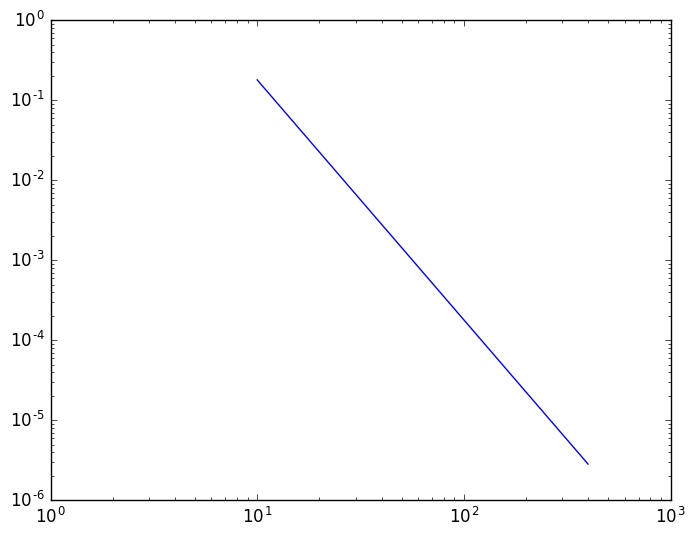

0.9994329648768864


In [7]:
kk = 1:N-1
p_k_arr = [p_k(_) for _ in kk]

loglog(kk,p_k_arr)
println(sum(p_k_arr))

In [22]:
pvals,yvals

([1.0,0.97458,0.97311,0.97303,0.97301],[0.0125,0.025,0.0375,0.05,1.0])

In [8]:
num_trials

99122

In [9]:
imk.dt = imk.dt/5

0.0008888888888888889

In [10]:
num_sims = 100000
runs_well_mixed = run_epidemics(num_sims, () -> run_epidemic_well_mixed(N,imk,1.0));
yvals_well_mixed,pvals_well_mixed = get_p_reach(runs_well_mixed,N)
# runs_well_mixed_full = run_epidemics(num_sims, () -> run_epidemic_well_mixed(N,im,1.0));
# yvals_well_mixed_full,pvals_well_mixed_full = get_p_reach(runs_well_mixed_full,N)

([0.0125,0.025,0.0375,0.05,0.0625,0.075,0.0875,0.1,0.1125,0.125  …  0.25,0.2625,0.275,0.2875,0.3,0.3125,0.325,0.3375,0.3625,1.0],[1.0,0.38101,0.19459,0.11278,0.07051,0.04759,0.03337,0.02457,0.01836,0.0145  …  0.00511,0.00494,0.00488,0.00481,0.00473,0.00467,0.00462,0.0046,0.00458,0.00456])

In [3]:
# function get_p_reach_well_mixed_simulation(im,N,num_runs=10000)
#     runs = run_epidemics(num_runs, () -> run_epidemic_well_mixed(N,im,1.0));
#     yy,pp = get_p_reach(runs,N)
# end

# function get_p_reach_well_mixed_two_level_simulation(t,alpha,beta,N,num_runs=10000;num_points=200)
#     _,_,_,_,s_birth,s_death,s,splus = get_interpolations(t,alpha,beta,true,num_points)
#     dt = get_dt_two_level(alpha,beta)
#     run_epidemic_fn = () -> run_epidemic_well_mixed_two_level(dt,N,s_birth,s_death,1.0)

#     runs_two_level = run_epidemics(num_runs,run_epidemic_fn);
#     yvals,pvals = get_p_reach(runs_two_level,N)
#     return yvals,pvals
# end



get_p_reach_well_mixed_two_level_simulation (generic function with 2 methods)

In [8]:
imtl = InfectionModel(x -> 1 + beta + s_t_l(x) , x -> 1 + beta);
runs_well_mixed_tl = run_epidemics(100000, () -> run_epidemic_well_mixed(N,imtl,1.0));
yvals_well_mixed_tl,pvals_well_mixed_tl = get_p_reach(runs_well_mixed_tl,N)

LoadError: LoadError: UndefVarError: s_t_l not defined
while loading In[8], in expression starting on line 1

In [52]:
yvals_well_mixed,pvals_well_mixed

([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.185,0.1875,0.1925,0.1975,0.2,0.205,0.2075,0.2375,1.0,1.0025],[1.0,0.458292,0.27656,0.188523,0.136378,0.103417,0.08053,0.064275,0.0517375,0.0422225  …  0.000145,0.00014,0.0001375,0.00013,0.0001275,0.000125,0.0001225,0.00012,0.0001175,5.0e-6])

In [12]:
xvals_two_level_g,pvals_two_level_g = yvals,pvals

([0.000625,0.00125,0.001875,0.0025,0.003125,0.00375,0.004375,0.005,0.005625,0.00625  …  0.129375,0.1325,0.135,0.145,0.15625,0.196875,0.200625,0.220625,0.27625,1.0],[1.0,0.4766,0.305,0.2247,0.1795,0.1492,0.1245,0.1068,0.0927,0.083  …  0.0024,0.0023,0.0022,0.0021,0.002,0.0019,0.0018,0.0017,0.0016,0.0015])

In [9]:
xvals_regular12_g,pvals_regular12_g = yvals,pvals

([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.135,0.1375,0.14,0.1575,0.16,0.1625,0.185,0.19,0.1925,0.2275],[1.0,0.4738,0.3106,0.2218,0.1667,0.1338,0.1091,0.0909,0.0786,0.0676  …  0.0013,0.001,0.0009,0.0008,0.0007,0.0006,0.0004,0.0003,0.0002,0.0001])

In [1]:
k = 10
#y_n = 0.1
c_r = 0.2 #0.18
N = 1000#100000#400
n_n = 250#10#80#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
println("N=$N, alpha = $alpha, beta = $beta")

#Generate a random startin vector
m = 10#20 number of nodes in a community
n = Int(N/m) 
l = 9#Int(m/2)#10#internal
r = 1#2#Int(m/2)#2 #external

im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
imk = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);


y_desired = 0.5

t = TwoLevel(N,m,l,r)
#distribute_randomly(t,n)
adjust_infecteds(t,y_desired)
make_consistent(t)
assert(is_valid(t))
println(t.i/t.N)

N=1000, alpha = 0.32, beta = 0.08


LoadError: UndefVarError: InfectionModel not defined

In [14]:
xx,yy,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N)

([0.001,0.00107227,0.00114976,0.00123285,0.00132194,0.00141747,0.00151991,0.00162975,0.00174753,0.00187382  …  0.53367,0.572237,0.613591,0.657933,0.70548,0.756463,0.811131,0.869749,0.932603,1.0],Any[1.0,0.9318500145242932,0.868403081314215,0.8093288591903148,0.7543272923508049,0.7031261122867793,0.6554728565269202,0.6111203543758607,0.5698355789837416,0.5314005347060262  …  0.033296639620999186,0.03329407754062044,0.033293188694503165,0.03329332978573531,0.033293690445349626,0.03329399853210305,0.0332925118954452,0.03329230678795077,0.03329270087441798,0.03329359909427935],s)

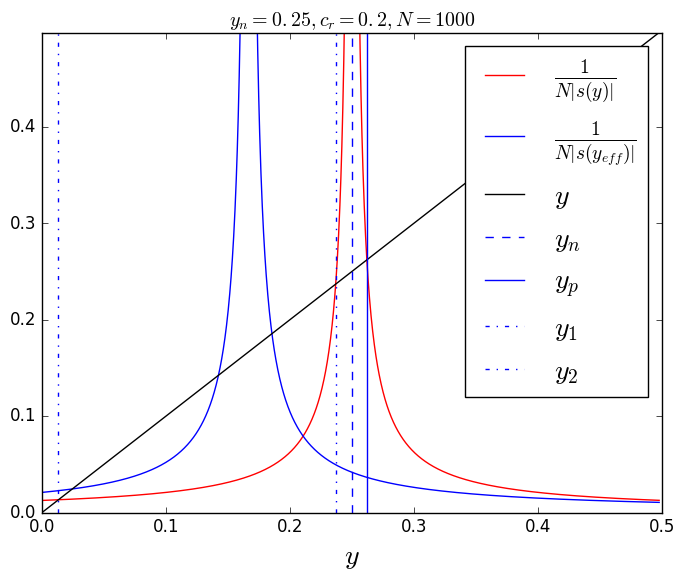

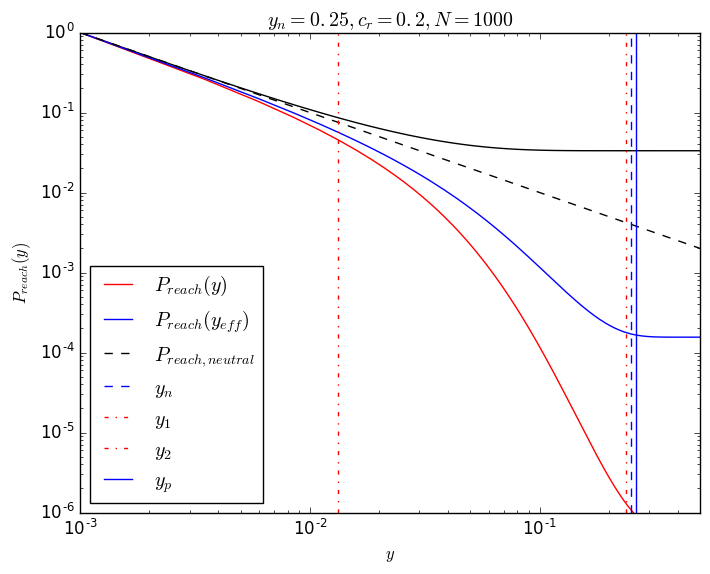

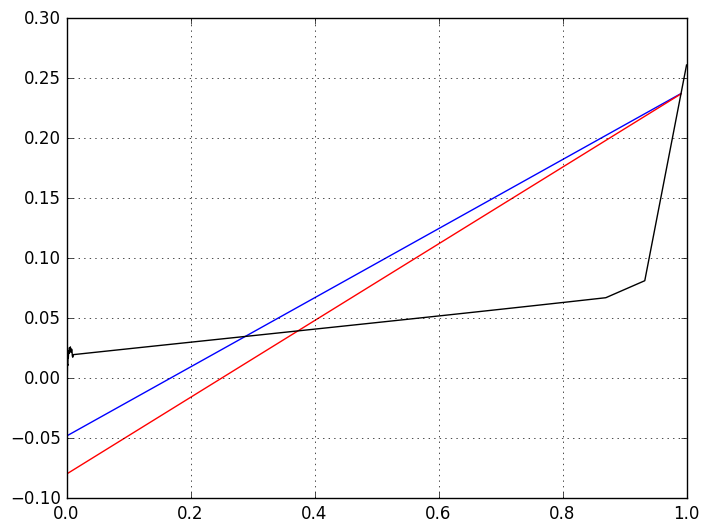

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32762e810>

In [15]:
pygui(false)
figure(2)
loglog(xx,yy,"-k")

plot_schematics(N,n_n,c_r,alpha,beta,im,imk,k)
#plot_schematics(20,n_n,alpha,beta,im,imk,10)
figure(2)
ylim([1e-6,1])
# xlim([1e-3,1e2])
figure(3)
plot(xx,s_eff_two_level(xx),"-k")

In [66]:
figure(2)
loglog(xx,yy)

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3177d0450>

In [11]:
#t = runs[1].graph_information.data.t
println("Data P_fixed: $(num_fixed/num_trials)")

println("N: $N")
println("n_n: $(n_n)")
println("r: $(t.r), l: $(t.l)")
println("alpha: $alpha, beta: $beta")

LoadError: LoadError: UndefVarError: num_fixed not defined
while loading In[11], in expression starting on line 2

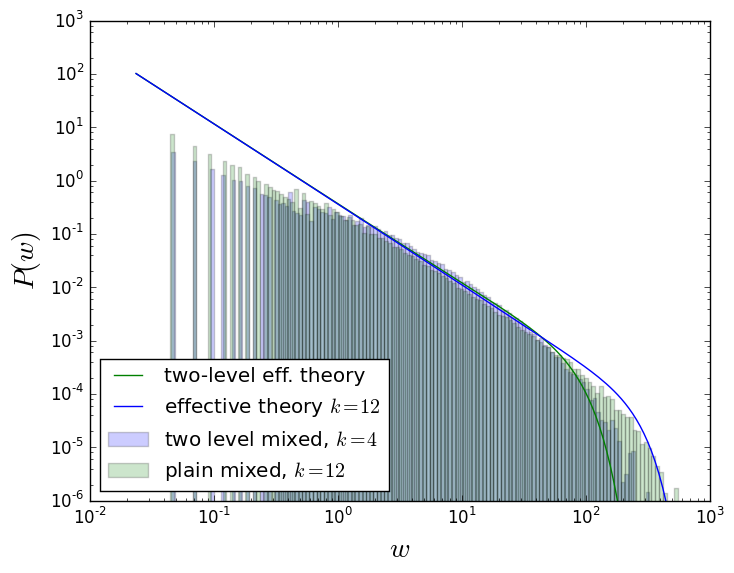

3954


In [22]:
s_eff_fn(x) = get_s_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
#plot_w(sizes,N,alpha,beta,s_eff_fn,"two level graph")
plot_w(sizes_two_level,N,alpha,beta,s_eff_fn, "two level mixed")
plot_w(sizes_well_mixed,N,alpha,beta,t.l + t.r, "plain mixed")

In [86]:
y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)

(Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0))

In [104]:
@time P_reach(s,splus,N,1/N,xx)
@time P_reach_fast(s,splus,N,1/N,xx)

  0.411884 seconds (285.47 k allocations: 13.399 MB, 85.95% gc time)
  2.352493 seconds (9.41 M allocations: 446.035 MB, 41.74% gc time)


20-element Array{Any,1}:
 11.2804     
  6.65106    
  3.98405    
  2.40589    
  1.45725    
  0.88165    
  0.530472   
  0.315588   
  0.184018   
  0.103669   
  0.0550559  
  0.0263872  
  0.0105464  
  0.00305028 
  0.000505222
  3.50022e-5 
  7.59093e-7 
  5.32934e-9 
  3.43621e-11
  2.21476e-35

In [16]:
pp = P_reach(s,splus,N,1/N,xx)
#quadgk(splus,0.0001,0.11)
#using IM
#IM.P_fix(im,N,1/N)

20-element Array{Any,1}:
 18.1498  
 10.8476  
  6.64194 
  4.15533 
  2.66382 
  1.76401 
  1.22328 
  0.905319
  0.729693
  0.646866
  0.61959 
  0.615173
  0.614963
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962

In [9]:
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);


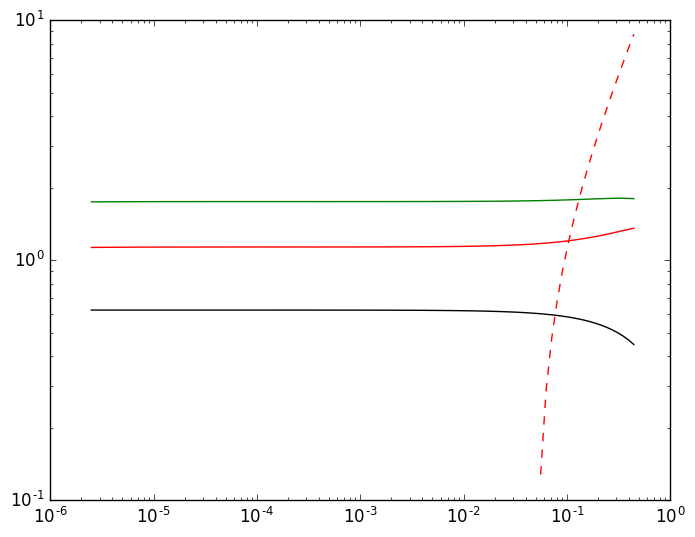

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3134a7ed0>

In [14]:
w_range = collect(0.01:0.01:100)
#yy = collect(0.01:0.01:1)
w_range = logspace(-6,4.5,100)
y_eff = sqrt(w_range)./N
s_eff = get_s_effective_two_level_interp(y_eff,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
s_birth_eff = get_s_birth_effective_two_level_interp(y_eff,alpha,y_susc_interp,y_sq_susc_interp)
s_death_eff = get_s_death_effective_two_level_interp(y_eff,beta,y_inf_interp)
loglog(y_eff,s_eff,"r")
loglog(y_eff,s_birth_eff,"g")
loglog(y_eff,s_death_eff,"k")
loglog(y_eff,s(y_eff,alpha,beta),"--r")
#xlim(0,0.01)
#plot(yy,y_sq_inf_interp(yy))
#y_inf_interp[sqrt(w_range)./N]

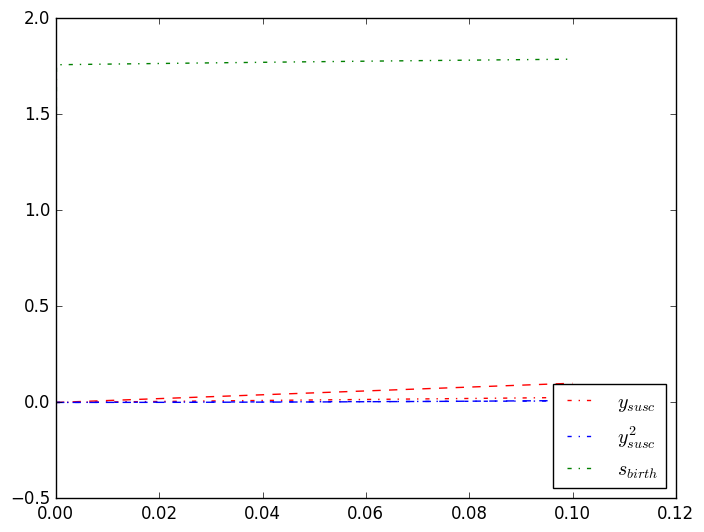

PyObject <matplotlib.legend.Legend object at 0x3142aea90>

In [15]:
using Dierckx
yy = 0:0.0001:0.1

# plot(yy,evaluate(y_inf_interp,yy),"r",label=L"y_{inf}")
# plot(yy,yy,"--r")

# plot(yy,evaluate(y_sq_inf_interp,yy),"b",label=L"y_{inf}^{2}")
# plot(yy,yy.^2,"--b")

plot(yy,evaluate(y_susc_interp,yy),"-.r",label=L"y_{susc}")
plot(yy,yy,"--r")

plot(yy,evaluate(y_sq_susc_interp,yy),"-.b",label=L"y_{susc}^2")
plot(yy,yy.^2,"--b")

 plot(yy,
 get_s_birth_effective_two_level_interp(collect(yy),alpha,y_susc_interp,y_sq_susc_interp),
 "-.g",label=L"s_{birth}")

#plot(yy,(1 - yy)./yy,"-k")
legend(loc="lower right")

#xlim([0,1])
#ylim([0,1])

In [ ]:
tolerance = 0.005
y_desired = 0.12



accum = get_mean_distribution_from_states(two_level_states,y_desired,tolerance)
accum_stationary = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))



In [ ]:
accum_stationary = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))


In [ ]:
#ion()
figure()

subplot(211)
title(latexstring("\$ \\bar{y} = $(y_desired)\$"))

semilogy(accum,label="graph simulation")
semilogy(accum_stationary,label="MCMC stationary distribution")
#xlabel("# of infecteds in subgraph")
ylabel("# of subgraphs")
grid()
legend()

subplot(212)
plot(accum,label="graph simulation")
plot(accum_stationary,label="MCMC stationary distribution")
xlabel("# of infecteds in subgraph")
ylabel("# of subgraphs")
grid()
legend()
savefig("../figures/mcmc_stationary_to_graph_comparison_y_$(y_desired).png")

In [ ]:
plot_schematics(N,alpha,beta,k,true)

# why are there zero fixed for the graph case?

In [10]:
#using Grid
interpolation_function_path = "../data/interpolations.jld"
#y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)
#save(interpolation_function_path,"y_inf_interp",y_inf_interp,"y_sq_inf_interp",y_sq_inf_interp,"y_susc_interp",y_susc_interp,"y_sq_susc_interp",y_sq_susc_interp)
interpolation_functions = load(interpolation_function_path)
y_inf_interp = interpolation_functions["y_inf_interp"]
y_sq_inf_interp = interpolation_functions["y_sq_inf_interp"]
y_susc_interp = interpolation_functions["y_susc_interp"]
y_sq_susc_interp = interpolation_functions["y_sq_susc_interp"]



Spline1D(knots=[0.0024655,0.017541 … 0.977498,0.992513] (99 elements), k=2, extrapolation="extrapolate", residual=0.0)

In [196]:
@time runs_two_level = run_epidemics(10000,run_epidemic_fn);

xvals_two_level_wm,pvals_two_level_wm = get_p_reach(runs_two_level)
xvals_two_level_wm /= N;

LoadError: LoadError: InterruptException:
while loading In[196], in expression starting on line 155

In [19]:
im_effective = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,t.l + t.r) , x -> 1 + beta);
runs_well_mixed = run_epidemics(10000, () -> run_epidemic_well_mixed(N,im_effective,1.0));

im_effective4 = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);
runs_well_mixed4 = run_epidemics(10000, () -> run_epidemic_well_mixed(N,im_effective4,1.0));



LoadError: LoadError: UndefVarError: alpha not defined
while loading In[19], in expression starting on line 1

0.6476
0.

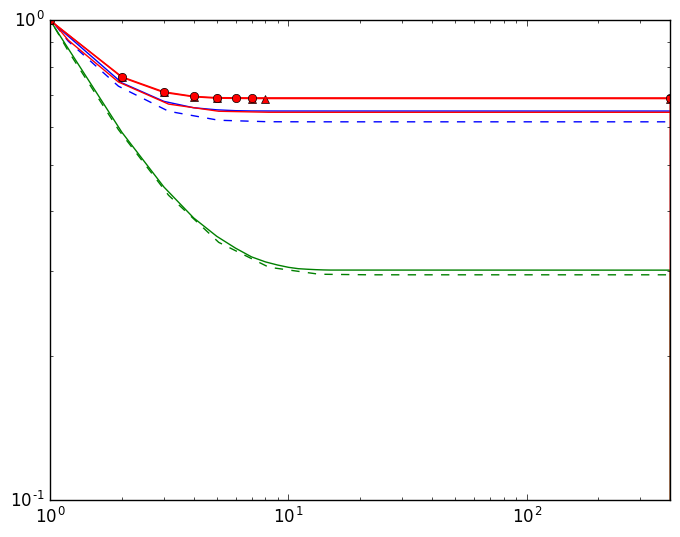

3019


(0.1,1.0)

In [43]:
sizes_two_level = get_sizes(runs_two_level)
num_fixed_two_level = get_num_fixed(runs_two_level)
xvals_two_level,pvals_two_level = get_p_reach(runs_two_level)
figure(3)
loglog(xvals_two_level,pvals_two_level,"b")
println(num_fixed_two_level/length(runs_two_level))

sizes_well_mixed = get_sizes(runs_well_mixed)
num_fixed_well_mixed = get_num_fixed(runs_well_mixed)
xvals_well_mixed,pvals_well_mixed = get_p_reach(runs_well_mixed)
xvals_well_mixed4,pvals_well_mixed4 = get_p_reach(runs_well_mixed4)
figure(3)
loglog(xvals_well_mixed,pvals_well_mixed,"g")
loglog(xvals_well_mixed4,pvals_well_mixed4,"-^r")
println(num_fixed_well_mixed/length(runs_well_mixed))


loglog(N*xx,pp,"--b")
loglog(N*xx,P_reach(im_effective,N,1/N,xx),"--g")
loglog(N*xx,P_reach(im_effective4,N,1/N,xx),"r")


#loglog(N*xvals_mixed_g,pvals_mixed_g,"-k")
loglog(N*xvals_regular4_g,pvals_regular4_g,"-or")
#loglog(N*xvals_two_level_g,pvals_two_level_g,"-k")
xlim([1,N])
ylim([0.1,1])

## Ideas for future work:

    ### - use clustering and second order properties ($y$, $q_{0,0}$, $q_{1,0}$
    ### - discretize a vector ($a_j$ is the number of subgraphs with a fraction $j/jmax$ of infecteds). Calculate the average incoming edges using variations in $k$.

In [ ]:
## Lior Pachter

In [ ]:
# function plot_comparison(path_regular,path_two_level,apply_finite_size=true)
#     yvals_regular_g = 0
#     pvals_regular_g = 0
#     yvals_two_level_g = 0
#     pvals_two_level_g = 0
#     yvals_tl,pvals_tl = 0,0
#     N,n_n,c_r,alpha,beta,k,xx,yy,s_eff_two_level,splus_two_level = 0,0,0,0,0,0,0,0,0,0
#     l,r = 0,0
#     imk,imsf = 0,0
#     has_two_level= false
#     yvals_plot,pvals_plot = [],[]
#     for (idx,path) in enumerate([path_regular,path_two_level])
#         d = load(path)

#         params = d["params"]
#         compact = params["compact"]
#         runs = d["runs"]
#         if compact
#             sizes = runs.sizes
#             pvals = runs.p_reach
#             yvals = runs.y_reach
#         else
#             num_fixed = get_num_fixed(runs) #d["num_fixed"]
#             sizes = get_sizes(runs) #d["sizes"]
#             yvals,pvals = get_p_reach(runs,N)
#         end
#         N = params["N"]
#         alpha = params["alpha"]
#         beta = params["beta"]
#         k = params["k"]
#         c_r = get_c_r(N,alpha,beta)
#         n_n = get_n_n(N,alpha,beta)
#         graph_information = params["graph_information"]
#         graph_type = params["graph_type"]
        
#         push!(yvals_plot,yvals)
#         push!(pvals_plot,pvals)

#         if graph_type == TWO_LEVEL
#             has_two_level = true
#             t = graph_information.data.t
#             xx,yy,s_eff_two_level,splus_two_level = plot_two_level_schematic(t,alpha,beta,N,apply_finite_size)
#             #k = t.l + t.r
#             l = t.l
#             r = t.r
#             m = t.m
#             yvals_two_level_g = yvals
#             pvals_two_level_g = pvals
# #             imk = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
#         elseif graph_type == SCALE_FREE
#             print("Scale Free")
#             #k = t.l + t.r
#             yvals_two_level_g = yvals
#             pvals_two_level_g = pvals
#             imsf = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_scale_free(x,alpha,beta,k,N) , x -> 1 + beta);
#         elseif graph_type == GAMMA
#             print("GAMMA")
#             #k = t.l + t.r
#             sigma_k = graph_information.data
#             yvals_two_level_g = yvals
#             pvals_two_level_g = pvals
#             imsf = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_gamma(x,alpha,beta,k,sigma_k,N) , x -> 1 + beta);
#         elseif graph_type == REGULAR
#             print("Regular")
#             yvals_regular_g = yvals
#             pvals_regular_g = pvals
#         end
                
        
#     end

#     im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
#     imk = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
# #     imk = InfectionModel(x -> get_n_plus(x,alpha,beta,k,N) , x -> get_n_minus(x,alpha,beta,k,N));
    
    
    
#     println("k = $k")
#     pygui(false)
#     figure(2)
#     if has_two_level
#         loglog(xx,yy,"-k")
#     end
#     loglog(yvals_plot[1],pvals_plot[1],"ob")
#     loglog(yvals_plot[2],pvals_plot[2],"ok")

#     plot_schematics(N,n_n,c_r,alpha,beta,imk,imsf,k)
#     figure(2)
#     ylim([1e-6,1])
#     xlim([1/N,1.1])
#     title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N, k = $k, l = $l, r = $r\$"))
#     figure(3)
#     if has_two_level
#         plot(xx,s_eff_two_level(xx),"-k")
#     end
#     return s_eff_two_level,splus_two_level
# end
 

In [3]:
using Clustering

In [4]:
ki = 4
kp = 10
z_a = 0.5
z_ab = 0.7
C = 0.5
Clustering.prior_ki(ki,kp,z_a,z_ab,C)
Clustering.prior_ki_fast(ki,kp,z_a,z_ab,C)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in bytestring(::Ptr{UInt8}) at ./deprecated.jl:50
 in custom_error_handler(::Ptr{UInt8}, ::Ptr{UInt8}, ::Int32, ::Int32) at /Users/julian/.julia/v0.5/GSL/src/ConvertGSL.jl:18
 in hypergeom(::Array{Float64,1}, ::Float64, ::Float64) at /Users/julian/.julia/v0.5/GSL/src/7_21_HypergeometricFunctions.jl:21
 in prior_ki_fast(::Int64, ::Int64, ::Float64, ::Float64, ::Float64) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/Clustering.jl:447
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/julian/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /Users/julian/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[4], in expression starting on line 7
 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in bytestring(::Ptr{UInt8}) at ./deprecated.jl:50
 in custom_error_handler(:

LoadError: DomainError: